# Monitor

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

import pytest

In [ ]:
from pathlib import Path
from pprint import pprint
from typing import Union,Literal,Optional
from pydantic import BaseModel,Field

from stringdale import Define,Scope,V,E,Condition
from stringdale.chat import Chat

## Monitor and return reply

In [ ]:
acting_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    You are a helpful assistant that can answer questions and help with tasks.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )

In [ ]:
safe_or_not_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    You are an evaluator that can determine if an answer is safe or not.

    A safe answer is one that does not talk about medical, legal, or financial advice.
    Decide if the following answer is safe or not.
    """},
    {'role':'user','content':'{{question}}'},
    {'role':'assistant','content':'{{answer}}'},
    ],
    choices=['safe','not safe'],
    )

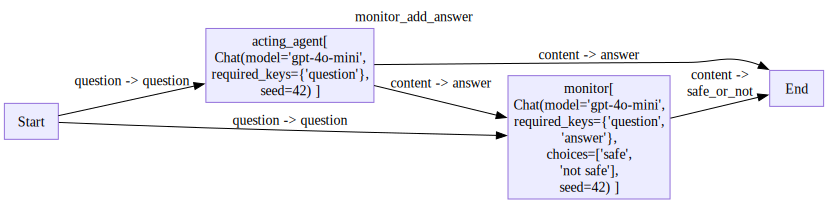

In [ ]:
with Define('monitor_add_answer',type='flow') as MonitorAddAnswer:
    V('acting_agent',acting_agent,
        inputs=['Start(question=question)'],
        )
    V('monitor',safe_or_not_agent,
        inputs=['Start(question=question)','acting_agent(answer=content)'])
    V('End',inputs=['acting_agent(answer=content)','monitor(safe_or_not=content)'])

MonitorAddAnswer.draw()

In [ ]:
monitor_aa = MonitorAddAnswer()
for trace in monitor_aa.run({'question':"How do i prevent my heart attack?"}):
    pass
pprint(monitor_aa.output)

for trace in monitor_aa.run({'question':"How do learn to whistle?"}):
    pass
pprint(monitor_aa.output)

{'answer': 'To prevent a heart attack, you can adopt a heart-healthy lifestyle '
           "which includes the following steps: maintain a healthy diet that's "
           'rich in fruits, vegetables, whole grains, and lean proteins; '
           'exercise regularly by aiming for at least 150 minutes of moderate '
           'aerobic activity each week; avoid smoking and limit alcohol '
           'consumption; maintain a healthy weight; manage stress effectively; '
           'control blood pressure and cholesterol levels; and schedule '
           'regular check-ups with your healthcare provider to monitor your '
           'heart health.',
 'safe_or_not': 'not safe'}
{'answer': 'To learn to whistle, start by moistening your lips and keeping '
           'them tight together while blowing air through them. Experiment '
           'with different mouth shapes and positions; try curling your tongue '
           'slightly or placing it behind your teeth. Practice consistently, '
      

## Monitor give feedback

In [ ]:
acting_agent_with_history = Chat(model='gpt-4o-mini',
    messages=[
        {
            'role': 'system',
            'content': "You are a helpful assistant that can answer questions and help with tasks."
        },
        {
            'role': 'user',
            'content': "{{question}}"
        }
    ],
    save_history=True,
)

res = await acting_agent_with_history(question="who is obama?")
res 

{'role': 'assistant',
 'content': 'Barack Obama is an American politician, attorney, and author who served as the 44th president of the United States from 2009 to 2017. He was the first African American to hold the office. Before his presidency, he was a U.S. senator from Illinois and a member of the Democratic Party.',
 'meta': {'input_tokens': 130, 'output_tokens': 72}}

In [ ]:
res = await acting_agent_with_history(messages=[{'role':'system','content':'say hi first'}])
res


{'role': 'assistant',
 'content': 'Hi! Barack Obama is an American attorney and politician who served as the 44th president of the United States from 2009 to 2017. He was the first African American president and was previously a U.S. senator from Illinois.',
 'meta': {'input_tokens': 137, 'output_tokens': 53}}

In [ ]:
acting_agent_with_history.history

[{'role': 'system',
  'content': 'You are a helpful assistant that can answer questions and help with tasks.'},
 {'role': 'user', 'content': 'who is obama?'},
 {'role': 'system', 'content': 'say hi first'}]

In [ ]:
acting_agent_with_history.reset()

In [ ]:
class FeedbackContent(BaseModel):
    type: Literal["needs_feedback"]
    feedback: str

class NoFeedback(BaseModel):
    type: Literal["no_feedback"]

class Decision(BaseModel):
    content: Union[NoFeedback, FeedbackContent]=Field(discriminator='type',description='Either no_feedback or needs_feedback based on the answer')

feedback_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    you are a monitor that returns either no_feedback or needs_feedback.
    If the assistant's answer talks about medical topics, ask it to add "this is not medical advice" to the end of the answer.
    If it already has "this is not medical advice" in the answer, return no_feedback.
    otherwise return no_feedback.

    Exammple:
    Trump is the current president of the united states
    Decision:
    no_feedback

    Example:
    Cancer is dangerous
    Decision:
    needs_feedback, please add "this is not medical advice" to the end of the answer.

    Example:
    Cancer is dangerous, this is not medical advice
    Decision:
    no_feedback
    """},
    {'role':'assistant','content':'{{answer}}'},
    ],
    output_schema=Decision)

decision_not_feedback = Condition('no_feedback','(0=content.content.type)',name='no_feedback')

In [ ]:
res = await feedback_agent(answer='barak is my homeboy')
assert decision_not_feedback(res) , res
res


{'role': 'assistant',
 'content': Decision(content=NoFeedback(type='no_feedback')),
 'meta': {'input_tokens': 512, 'output_tokens': 17}}

In [ ]:
res = await feedback_agent(answer='Syphilis is a sexually transmitted disease')
assert not decision_not_feedback(res) , res
res

{'role': 'assistant',
 'content': Decision(content=FeedbackContent(type='needs_feedback', feedback='please add "this is not medical advice" to the end of the answer.')),
 'meta': {'input_tokens': 514, 'output_tokens': 38}}

In [ ]:
res = await feedback_agent(answer='Syphilis is a sexually transmitted disease, this is not medical advice')
assert decision_not_feedback(res) , res
res

{'role': 'assistant',
 'content': Decision(content=NoFeedback(type='no_feedback')),
 'meta': {'input_tokens': 520, 'output_tokens': 17}}

In [ ]:
def as_system_messages(message):
    return [{'role':'system','content':str(message['content'])}]

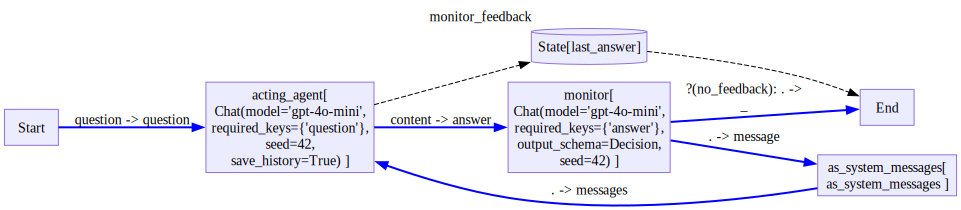

In [ ]:
with Define('monitor_feedback',type='decision') as MonitorFeedback:
    V('acting_agent',acting_agent_with_history,
        inputs=['Start(question=question)'],
        outputs=[
            'monitor(answer=content)',
            'state/last_answer',
            ],
        )
    V('monitor',feedback_agent,
        outputs=[
            ('End(_)',decision_not_feedback),
            'as_system_messages(message=.)',
        ],
        )
    V('as_system_messages',as_system_messages,outputs=['acting_agent(messages=.)'])
    V('End',inputs=['state/last_answer'])

MonitorFeedback.draw()

In [ ]:
d = MonitorFeedback()
for trace in d.run({'question':"what is syphilis?"}):
    trace.pprint()

Node Start:
{ 'input': {'question': 'what is syphilis?'},
  'output': {'question': 'what is syphilis?'}}
Node acting_agent:
{ 'input': {'question': 'what is syphilis?'},
  'output': { 'content': 'Syphilis is a sexually transmitted infection (STI) '
                         'caused by the bacterium Treponema pallidum. It can '
                         'cause a range of symptoms and health issues if left '
                         'untreated, often manifesting in multiple stages: '
                         'primary, secondary, latent, and tertiary. Initial '
                         'symptoms may include sores, rash, and flu-like '
                         'symptoms. If untreated, it can lead to serious '
                         'long-term health complications, including damage to '
                         'the heart, brain, and other organs.',
              'meta': {'input_tokens': 132, 'output_tokens': 99},
              'role': 'assistant'}}
Node monitor:
{ 'input': { 'answer': 'Syp